Toolset for calculating feature importance based on multiple methods:

- Hierarchical clustered Spearman correlation diagram
- linear/log-scaled Bayesian Linear Regression
- Random Forest Permutation Importance
- Model-agnostic correlation coefficients 
(see "A new coefficient of correlation" Chatterjee, S. (2019, September 22)

This script can also generate synthetic data and includes tests for all methods,
which can be used to compare the results.

User settings, such as input/output paths and all other options, are set in the settings file 
(Default filename: settings_featureimportance.yaml) 
Alternatively, the settings file can be specified as a command line argument with: 
'-s', or '--settings' followed by PATH-TO-FILE/FILENAME.yaml 
(e.g. python featureimportance.py -s settings_featureimportance.yaml).

This Jupyter notebook is build upon the python module `featureimportance.py` and imports its core functions.
To edit any of this functions, please do so in `featureimportance.py`

Requirements:
- python>=3.9
- matplotlib>=3.5.1
- numpy>=1.22.0
- pandas>=1.3.5
- PyYAML>=6.0
- scikit_learn>=1.0.2
- scipy>=1.7.3
- xicor>=1.0.1

Computational Constraints: 
    - 1000 samples with 20 features: less than 1min
    - for more than 10,000 samples or large number of features, it is recommended 
	to disable first function 'calc_new_correlation()' and second 'rf_factor_importance()'.

For more package details see conda environment file: environment.yaml

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).

Copyright 2022 Sebastian Haan, Sydney Informatics Hub (SIH), The University of Sydney

This open-source software is released under the AGPL-3.0 License.

In [41]:
import os
import itertools
import sys
import yaml
import shutil
import argparse
import datetime
from types import SimpleNamespace  
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import matplotlib as mpl
import matplotlib.pyplot as plt
# Try to import xicor module
try:
    from xicor.xicor import Xi
except ImportError:
    # If not installed, install from github
    print("xicor not installed. Attempt to install xicor package from github...")
    !pip install git+git://github.com/czbiohub/xicor/
    from xicor.xicor import Xi


Import custom modules

In [42]:
sys.path.append("../python_scripts/")
from featureimportance import (create_simulated_features, 
	plot_feature_correlation_spearman, 
	calc_new_correlation, 
	blr_factor_importance, 
	plot_correlationbar,
	rf_factor_importance,
	gradientbars)

Settings yaml file

In [43]:
_fname_settings = 'settings_featureimportance_simulation.yaml'

Log computational time

In [44]:
datetime_start = datetime.datetime.now()


<br>
Main function for running the script.<br>
<br>
Load settings from yaml file

In [45]:
with open(_fname_settings, 'r') as f:
	settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

Verify output directory and make it if it does not exist

In [46]:
os.makedirs(settings.outpath, exist_ok = True)

Read data

In [47]:
data_fieldnames = settings.name_features + [settings.name_target]
df = pd.read_csv(os.path.join(settings.inpath, settings.infname), usecols=data_fieldnames)

Verify that data is cleaned:

In [48]:
assert df.select_dtypes(include=['number']).columns.tolist().sort() == data_fieldnames.sort(), 'Data contains non-numeric entries.'
assert df.isnull().sum().sum() == 0, "Data is not cleaned, please run preprocess_data.py before"

1) Generate Spearman correlation matrix

Calculate Spearman correlation matrix...


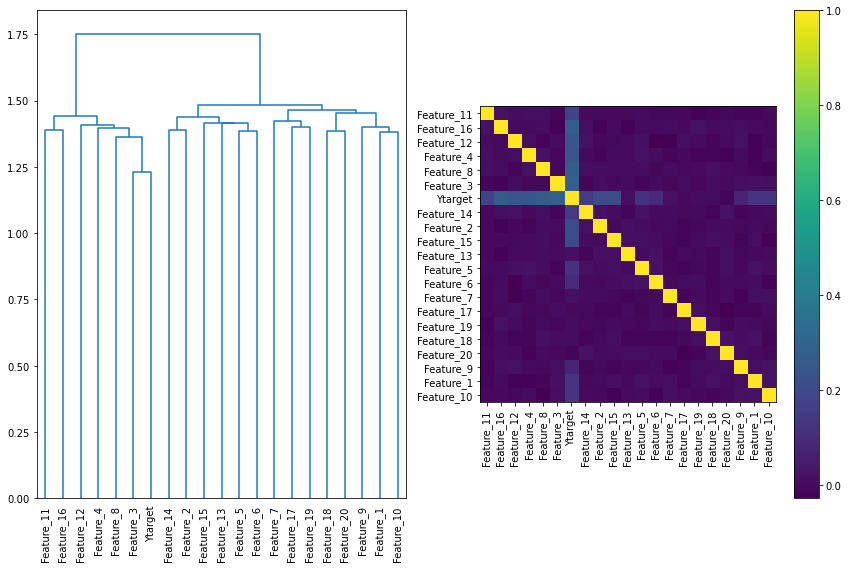

In [49]:
print("Calculate Spearman correlation matrix...")
plot_feature_correlation_spearman(df[data_fieldnames].values, data_fieldnames, settings.outpath, show = False)

2) Generate feature importance based on model-agnostic correlation 

Calculate feature importance for model-agnostic correlations...


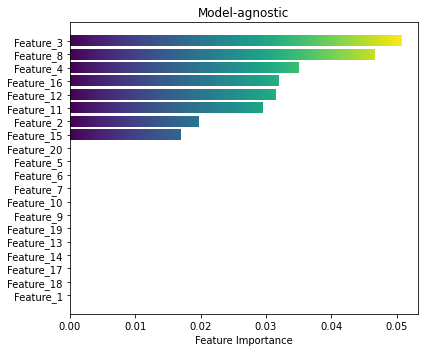

In [50]:
print("Calculate feature importance for model-agnostic correlations...")
X = df[settings.name_features].values
y = df[settings.name_target].values
corr = calc_new_correlation(X, y)
plot_correlationbar(corr, settings.name_features, settings.outpath, 'Model-agnostic-correlation.png', name_method = 'Model-agnostic', show = True)

3) Generate feature importance based on significance of Bayesian Linear Regression coeffcicients:

Calculate feature importance for Bayesian Linear Regression...


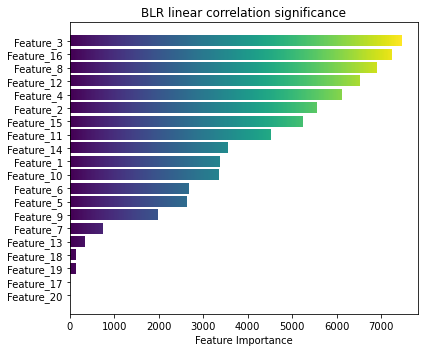

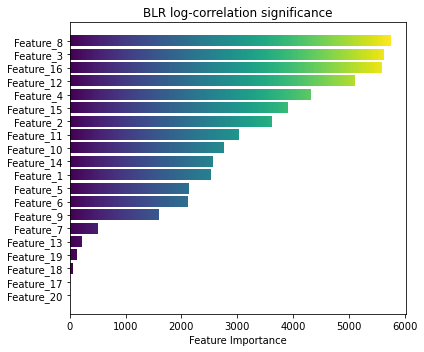

In [51]:
print("Calculate feature importance for Bayesian Linear Regression...")
corr = blr_factor_importance(X, y, logspace = False)
plot_correlationbar(corr, settings.name_features, settings.outpath, 'BLR-linear-correlation.png', name_method = 'BLR linear correlation significance', show = True)
# and in log-space
corr = blr_factor_importance(X, y, logspace = True)
plot_correlationbar(corr, settings.name_features, settings.outpath, 'BLR-log-correlation.png', name_method = 'BLR log-correlation significance', show = True)

4) Generate feature importance based on Random Forest permutation importance

Calculate feature importance for Random Forest permutation importance...


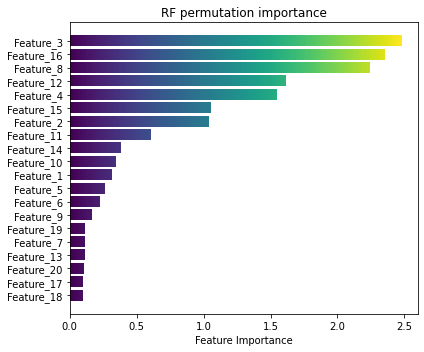

In [52]:
print("Calculate feature importance for Random Forest permutation importance...")
corr = rf_factor_importance(X, y)
plot_correlationbar(corr, settings.name_features, settings.outpath, 'RF-permutation-importance.png', name_method = 'RF permutation importance', show = True)

print out compute time of main function in seconds

In [53]:
print('Computational time of main function: {:.2f} seconds'.format((datetime.datetime.now() - datetime_start).total_seconds()))

Computational time of main function: 1030.19 seconds
